# Outlier Analysis: MRMR Benchmark Performance < 0

## Analysis of Negative R² Performance Across Models, Features, and Networks

This standalone script analyzes the distribution of outliers (model_performance < 0) 
in the MRMR benchmark results, focusing on identifying which combinations generate 
the most negative R² scores.

## Initialization and Setup

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set up project path and import path
path = os.getcwd()
index_project = path.find("project")
project_path = path[: index_project + 7]
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

# Add current working directory to Python path for imports
import sys
sys.path.insert(0, os.getcwd())

Project path set to: c:\Github\ode-biomarker-project


In [6]:
# Import PathLoader and DataLink after changing directory
from PathLoader import PathLoader
from DataLink import DataLink

# Initialize data access
path_loader = PathLoader("data_config.env", "current_user.env")
data_link = DataLink(path_loader, "data_codes.csv")

# Set up results directory (same as main analysis)
folder_name = "ThesisResult4-4-ModelSelectionGeneSubsets"
exp_id = "v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4"

main_folder = f"{path_loader.get_data_path()}data/results/{folder_name}"
exp_folder = f"{main_folder}/{exp_id}"
file_save_path = f"{exp_folder}/"

if not os.path.exists(main_folder):
    os.makedirs(main_folder)
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)

# Create print report for outlier analysis
outlier_report_path = f"{file_save_path}outlier_analysis_report_{exp_id}.md"
outlier_report_file = open(outlier_report_path, 'w', encoding='utf-8')

outlier_report_file.write(f"# Outlier Analysis Report - {exp_id}\n\n")
outlier_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
outlier_report_file.write("Analysis focused on identifying outlier patterns where model_performance < 0.\n\n")

def save_and_print(message, report_file=None, level="info"):
    """Save message to report file and print to console"""
    print(message)
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:
            report_file.write(f"{message}\n\n")

## Data Loading and Outlier Identification

In [9]:
# Load benchmark results
pkl_path = f"{exp_folder}/model_selection_benchmark_{exp_id}.pkl"
if not os.path.exists(pkl_path):
    raise FileNotFoundError(f"Benchmark results not found: {pkl_path}")

df_benchmark = pd.read_pickle(pkl_path)
save_and_print(f"Loaded benchmark data with shape: {df_benchmark.shape}", outlier_report_file, level="section")

# Identify outliers (model_performance < 0)
if "model_performance" in df_benchmark.columns:
    df_outliers = df_benchmark[df_benchmark["model_performance"] < 0]
    df_valid = df_benchmark[df_benchmark["model_performance"] >= 0]
    
    total_rows = len(df_benchmark)
    outlier_count = len(df_outliers)
    valid_count = len(df_valid)
    outlier_percentage = (outlier_count / total_rows) * 100
    
    save_and_print(f"## Outlier Summary Statistics", outlier_report_file, level="section")
    save_and_print(f"Total benchmark runs: {total_rows}", outlier_report_file, level="info")
    save_and_print(f"Outlier runs (R² < 0): {outlier_count}", outlier_report_file, level="info")
    save_and_print(f"Valid runs (R² ≥ 0): {valid_count}", outlier_report_file, level="info")
    save_and_print(f"Outlier percentage: {outlier_percentage:.1f}%", outlier_report_file, level="info")

# Parse model names from condition column (same logic as main analysis)
def parse_model_name_from_condition(condition):
    """Parse complete model name from condition column format"""
    parts = condition.split('_')
    model_parts = []
    for part in parts:
        if part.startswith('k'):
            break
        model_parts.append(part)
    complete_model_name = '_'.join(model_parts)
    return complete_model_name

if 'condition' in df_benchmark.columns and 'model_name' in df_benchmark.columns:
    df_benchmark['model_name'] = df_benchmark['condition'].apply(parse_model_name_from_condition)
    df_outliers['model_name'] = df_outliers['condition'].apply(parse_model_name_from_condition)

Loaded benchmark data with shape: (840, 19)
## Outlier Summary Statistics
Total benchmark runs: 840
Outlier runs (R² < 0): 486
Valid runs (R² ≥ 0): 354
Outlier percentage: 57.9%


C:\Users\l8105\AppData\Local\Temp\ipykernel_6360\3071594934.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers['model_name'] = df_outliers['condition'].apply(parse_model_name_from_condition)


In [10]:
df_benchmark['rng'].unique()

array([15795,   860, 76820, 54886,  6265, 82386, 37194, 87498, 44131,
       60263, 16023, 41090, 67221, 64820,   769, 59735, 62955, 64925,
       67969,  5311])

## Model-Specific Outlier Analysis

In [11]:
save_and_print("## Model-Specific Outlier Analysis", outlier_report_file, level="section")

# Analyze outlier distribution by model
model_outlier_stats = df_outliers.groupby('model_name').agg({
    'model_performance': ['count', 'mean', 'min'],
    'condition': 'count'
}).round(4)

model_valid_stats = df_valid.groupby('model_name').agg({
    'model_performance': ['count', 'mean'],
    'condition': 'count'
}).round(4)

# Calculate outlier percentages by model
model_counts_total = df_benchmark.groupby('model_name').size()
model_counts_outlier = df_outliers.groupby('model_name').size()
model_outlier_percentage = (model_counts_outlier / model_counts_total * 100).round(1)

model_summary = pd.DataFrame({
    'total_runs': model_counts_total,
    'outlier_runs': model_counts_outlier,
    'outlier_percentage': model_outlier_percentage,
    'mean_outlier_performance': df_outliers.groupby('model_name')['model_performance'].mean().round(4)
})

save_and_print("Outlier Distribution by Model:", outlier_report_file, level="subsection")
save_and_print(model_summary.sort_values('outlier_percentage', ascending=False).to_string(), outlier_report_file, level="info")

## Model-Specific Outlier Analysis
Outlier Distribution by Model:
                               total_runs  outlier_runs  outlier_percentage  mean_outlier_performance
model_name                                                                                           
MLPRegressor_config2                  120           110                91.7             -1.326615e+36
MLPRegressor_config1                  120           109                90.8             -5.408099e+36
LinearRegression                      120            85                70.8             -7.597382e+38
SVR                                   120            85                70.8             -3.814067e+36
KNeighborsRegressor                   120            56                46.7             -1.367000e-01
RandomForestRegressor_config1         120            24                20.0             -9.260000e-02
RandomForestRegressor_config2         120            17                14.2             -5.290000e-02


## Feature Type Outlier Analysis

In [12]:
save_and_print("## Feature Type Outlier Analysis", outlier_report_file, level="section")

# Analyze outliers by feature type (dataset_type)
feature_outlier_stats = pd.DataFrame({
    'total_runs': df_benchmark.groupby('dataset_type').size(),
    'outlier_runs': df_outliers.groupby('dataset_type').size(),
    'outlier_percentage': (df_outliers.groupby('dataset_type').size() / df_benchmark.groupby('dataset_type').size() * 100).round(1),
    'mean_outlier_performance': df_outliers.groupby('dataset_type')['model_performance'].mean().round(4),
    'mean_valid_performance': df_valid.groupby('dataset_type')['model_performance'].mean().round(4)
})

save_and_print("Outlier Distribution by Feature Type:", outlier_report_file, level="subsection")
save_and_print(feature_outlier_stats.to_string(), outlier_report_file, level="info")

## Feature Type Outlier Analysis
Outlier Distribution by Feature Type:
              total_runs  outlier_runs  outlier_percentage  mean_outlier_performance  mean_valid_performance
dataset_type                                                                                                
combined             280           171                61.1             -2.194826e+38                  0.1760
dynamic              280           196                70.0             -1.433971e+38                  0.1735
genesubset           280           119                42.5             -3.312000e-01                  0.1855


## Network-Specific Outlier Analysis

In [13]:
save_and_print("## Network-Specific Outlier Analysis", outlier_report_file, level="section")

# Analyze outliers by network type
network_outlier_stats = pd.DataFrame({
    'total_runs': df_benchmark.groupby('network_type').size(),
    'outlier_runs': df_outliers.groupby('network_type').size(),
    'outlier_percentage': (df_outliers.groupby('network_type').size() / df_benchmark.groupby('network_type').size() * 100).round(1),
    'mean_outlier_performance': df_outliers.groupby('network_type')['model_performance'].mean().round(4),
    'mean_valid_performance': df_valid.groupby('network_type')['model_performance'].mean().round(4)
})

save_and_print("Outlier Distribution by Network:", outlier_report_file, level="subsection")
save_and_print(network_outlier_stats.to_string(), outlier_report_file, level="info")

## Network-Specific Outlier Analysis
Outlier Distribution by Network:
              total_runs  outlier_runs  outlier_percentage  mean_outlier_performance  mean_valid_performance
network_type                                                                                                
cdk46                420           194                46.2             -3.383369e+38                  0.2361
fgfr4                420           292                69.5             -8.902494e+05                  0.0803


## Combined Analysis: Model × Feature × Network Outlier Patterns

In [14]:
save_and_print("## Combined Outlier Analysis", outlier_report_file, level="section")

# Create cross-tabulation of outliers across all dimensions
outlier_cross_tab = pd.crosstab(
    index=[df_outliers['model_name'], df_outliers['dataset_type']],
    columns=df_outliers['network_type'],
    values=df_outliers['condition'],
    aggfunc='count'
).fillna(0)

total_cross_tab = pd.crosstab(
    index=[df_benchmark['model_name'], df_benchmark['dataset_type']],
    columns=df_benchmark['network_type'],
    values=df_benchmark['condition'],
    aggfunc='count'
).fillna(0)

percentage_cross_tab = (outlier_cross_tab / total_cross_tab * 100).fillna(0).round(1)

save_and_print("Outlier Counts by Model × Feature × Network:", outlier_report_file, level="subsection")
save_and_print(outlier_cross_tab.to_string(), outlier_report_file, level="info")

save_and_print("Outlier Percentages by Model × Feature × Network:", outlier_report_file, level="subsection")
save_and_print(percentage_cross_tab.to_string(), outlier_report_file, level="info")

## Combined Outlier Analysis
Outlier Counts by Model × Feature × Network:
network_type                                cdk46  fgfr4
model_name                    dataset_type              
KNeighborsRegressor           combined        7.0   14.0
                              dynamic         6.0   17.0
                              genesubset      3.0    9.0
LinearRegression              combined       19.0   17.0
                              dynamic        18.0   17.0
                              genesubset      1.0   13.0
MLPRegressor_config1          combined       17.0   20.0
                              dynamic        20.0   20.0
                              genesubset     12.0   20.0
MLPRegressor_config2          combined       17.0   19.0
                              dynamic        20.0   20.0
                              genesubset     15.0   19.0
RandomForestRegressor_config1 combined        1.0    3.0
                              dynamic         1.0   13.0
              

## Publication-Quality Visualization Setup

In [15]:
# Configure publication-quality styling
publication_config = {
    'figure_size_small': (8, 6),
    'figure_size_medium': (10, 8),
    'font_sizes': {
        'title': 16,
        'axis_label': 14,
        'tick': 12,
        'value': 11
    },
    'dpi': 600
}

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Heatmap Visualizations

## Outlier Heatmap Visualizations


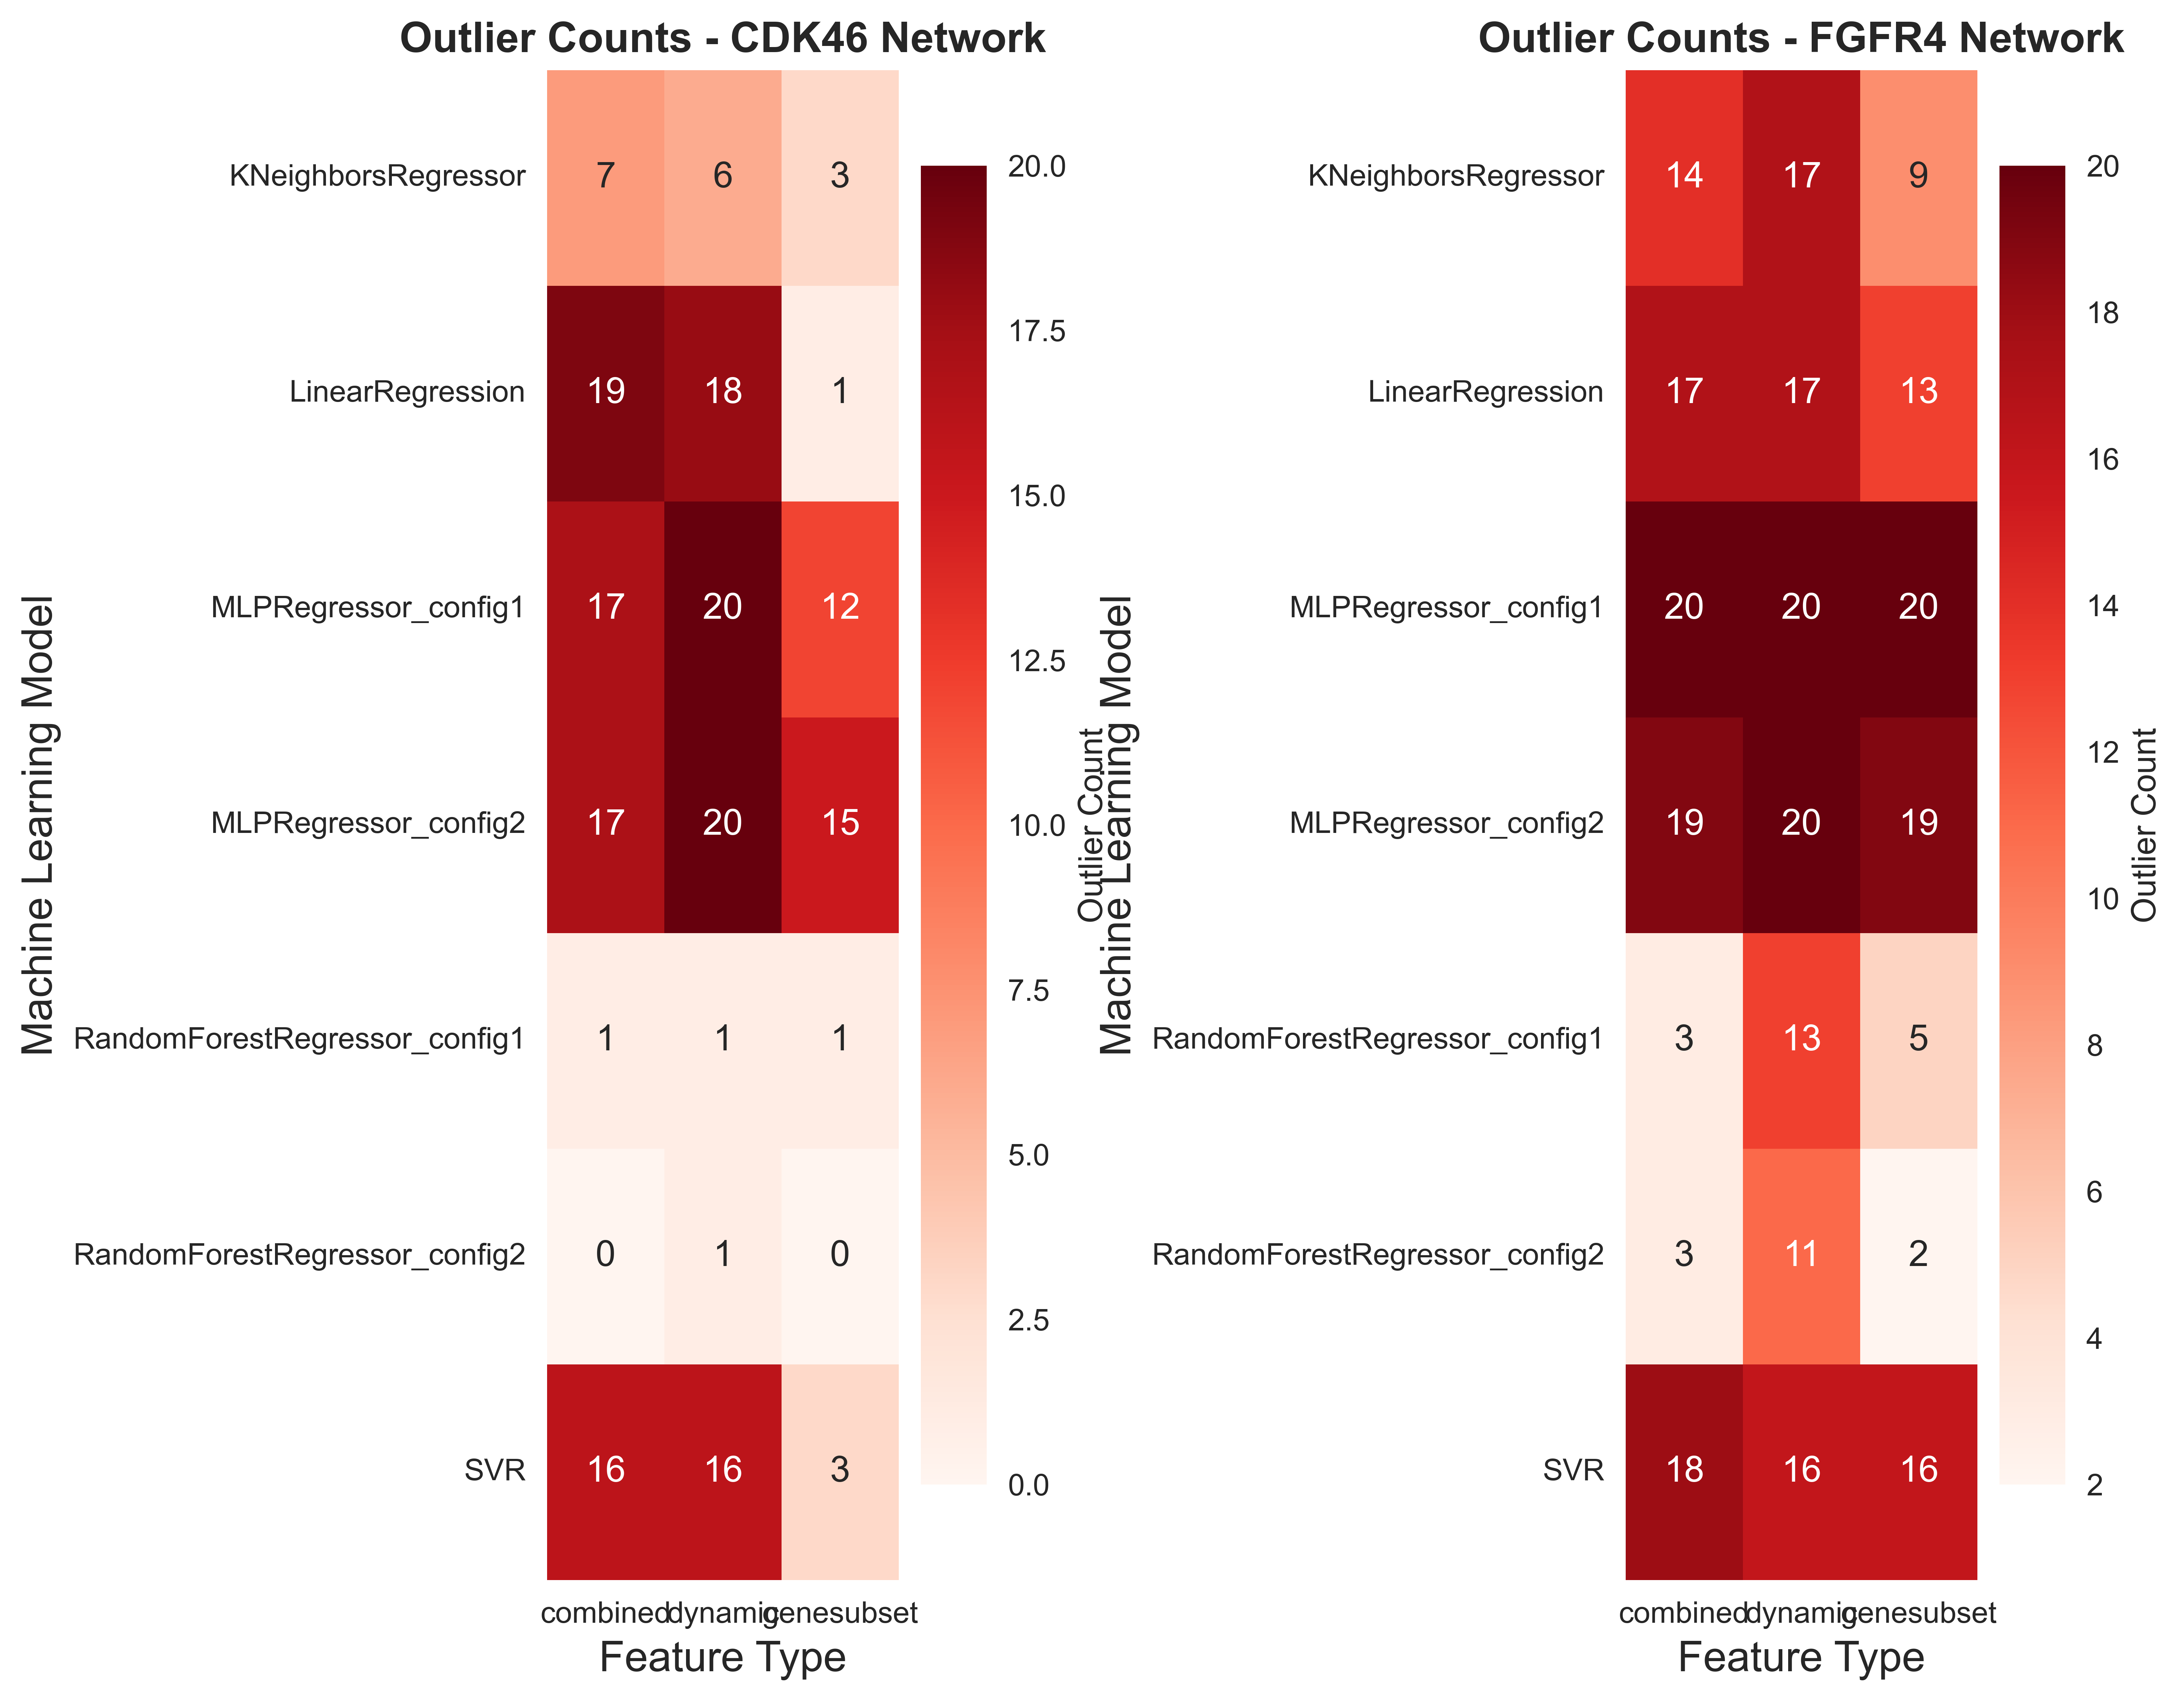

Created outlier counts heatmap by network


In [ ]:
save_and_print("## Outlier Heatmap Visualizations", outlier_report_file, level="section")

# Heatmap 1: Outlier counts by model and feature type (separated by network)
fig, axes = plt.subplots(1, 2, figsize=publication_config['figure_size_medium'], dpi=publication_config['dpi'])
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']

networks = df_benchmark['network_type'].unique()
for i, network in enumerate(networks):
    if i < len(axes):
        ax = axes[i]
        network_outliers = df_outliers[df_outliers['network_type'] == network]
        
        # Create pivot table for this network
        pivot_data = network_outliers.pivot_table(
            index='model_name', 
            columns='dataset_type', 
            values='condition', 
            aggfunc='count'
        ).fillna(0)
        
        sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='Reds', 
                    cbar_kws={'label': 'Outlier Count'}, ax=ax)
        ax.set_title(f'Outlier Counts - {network.upper()} Network', 
                     fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
        ax.set_xlabel('Feature Type', fontsize=publication_config['font_sizes']['axis_label'])
        ax.set_ylabel('Machine Learning Model', fontsize=publication_config['font_sizes']['axis_label'])

plt.tight_layout()
plt.savefig(f"{file_save_path}outlier_counts_heatmap_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Created outlier counts heatmap by network", outlier_report_file, level="info")

# Heatmap 2: Outlier percentages across all combinations
plt.figure(figsize=publication_config['figure_size_medium'], dpi=publication_config['dpi'])

# Create percentage heatmap
sns.heatmap(percentage_cross_tab, annot=True, fmt='.1f', cmap='Reds', 
            cbar_kws={'label': 'Outlier Percentage (%)'})
plt.title('Outlier Percentages by Model × Feature × Network', 
          fontsize=publication_config['font_sizes']['title'], fontweight='bold', pad=20)
plt.xlabel('Network Type', fontsize=publication_config['font_sizes']['axis_label'])
plt.ylabel('Model × Feature Type', fontsize=publication_config['font_sizes']['axis_label'])

plt.tight_layout()
plt.savefig(f"{file_save_path}outlier_percentages_heatmap_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Created outlier percentages heatmap", outlier_report_file, level="info")

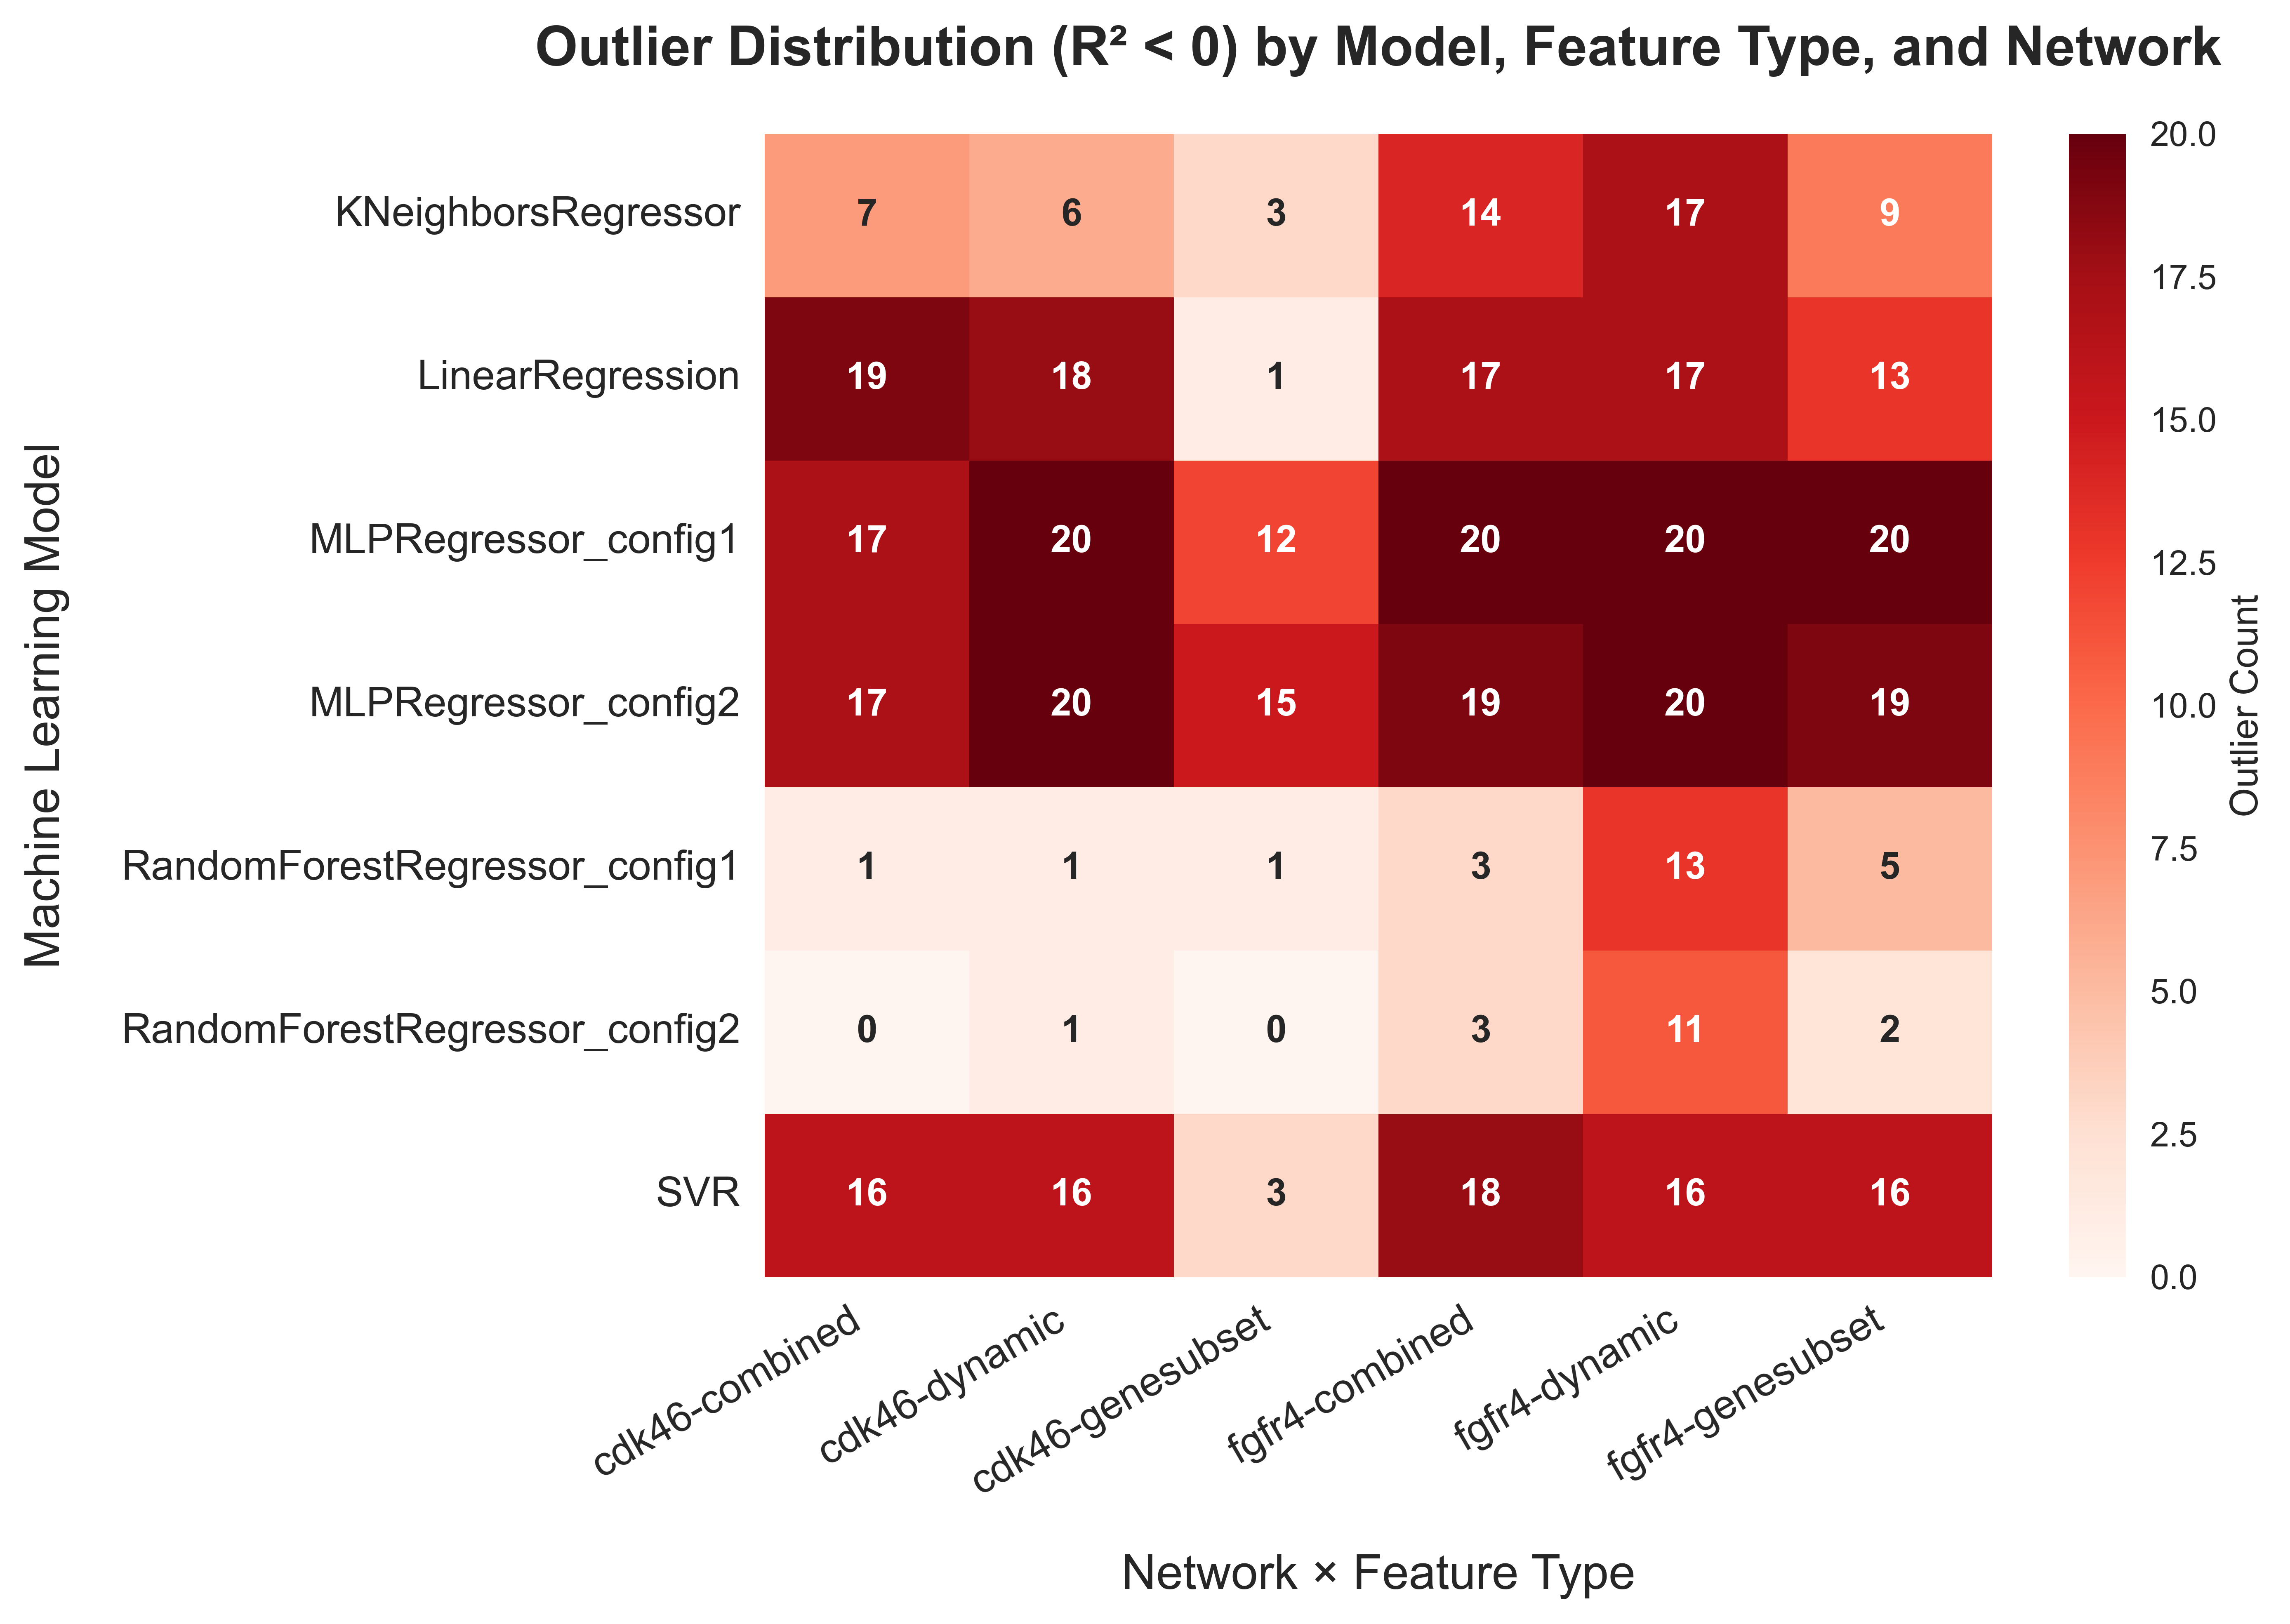

In [17]:
# save_and_print("## Outlier Heatmap Visualizations", outlier_report_file, level="section")

# Create copy to avoid SettingWithCopyWarning and add composite column
df_outliers = df_outliers.copy()
df_outliers['network_feature'] = df_outliers['network_type'] + '-' + df_outliers['dataset_type']

# Define column order EXACTLY as in target figure (Network × Feature Type)
column_order = [
    'cdk46-combined',
    'cdk46-dynamic',
    'cdk46-genesubset',
    'fgfr4-combined',
    'fgfr4-dynamic',
    'fgfr4-genesubset'
]

# Create pivot table with all combinations
pivot_data = df_outliers.pivot_table(
    index='model_name',
    columns='network_feature',
    values='condition',
    aggfunc='count',
    fill_value=0
)

# Reorder columns to match target visualization
pivot_data = pivot_data.reindex(columns=column_order)

# Define model order EXACTLY as in target figure
model_order = [
    'KNeighborsRegressor',
    'LinearRegression',
    'MLPRegressor_config1',
    'MLPRegressor_config2',
    'RandomForestRegressor_config1',
    'RandomForestRegressor_config2',
    'SVR'
]

# Reorder rows to match target visualization
pivot_data = pivot_data.reindex(index=model_order)

# Reset style to ensure clean baseline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with publication settings
plt.figure(figsize=publication_config['figure_size_small'], dpi=publication_config['dpi'])
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']

# Generate heatmap with proper styling
ax = sns.heatmap(
    pivot_data,
    annot=True,
    cmap='Reds',
    cbar_kws={'label': 'Outlier Count'},
    annot_kws={
        "size": publication_config['font_sizes']['value'],
        "weight": "bold"
    },
)

# Set title with publication config font size
ax.set_title(
    'Outlier Distribution (R² < 0) by Model, Feature Type, and Network', 
    fontsize=publication_config['font_sizes']['title'], 
    fontweight='bold', 
    pad=20
)

# Set axis labels with publication config font size
ax.set_xlabel(
    'Network × Feature Type', 
    fontsize=publication_config['font_sizes']['axis_label'], 
    labelpad=15
)
ax.set_ylabel(
    'Machine Learning Model', 
    fontsize=publication_config['font_sizes']['axis_label'], 
    labelpad=15
)

# Format tick labels with publication config font size
plt.xticks(
    rotation=30, 
    ha='right', 
    fontsize=publication_config['font_sizes']['tick']
)
plt.yticks(
    fontsize=publication_config['font_sizes']['tick']
)

plt.savefig(
    f"{file_save_path}outlier_distribution_heatmap_{exp_id}.png", 
    dpi=publication_config['dpi'], 
    bbox_inches='tight', 
    pad_inches=0.1
)
plt.show()

# save_and_print("Created target-matching outlier distribution heatmap with publication config styling", outlier_report_file, level="info")

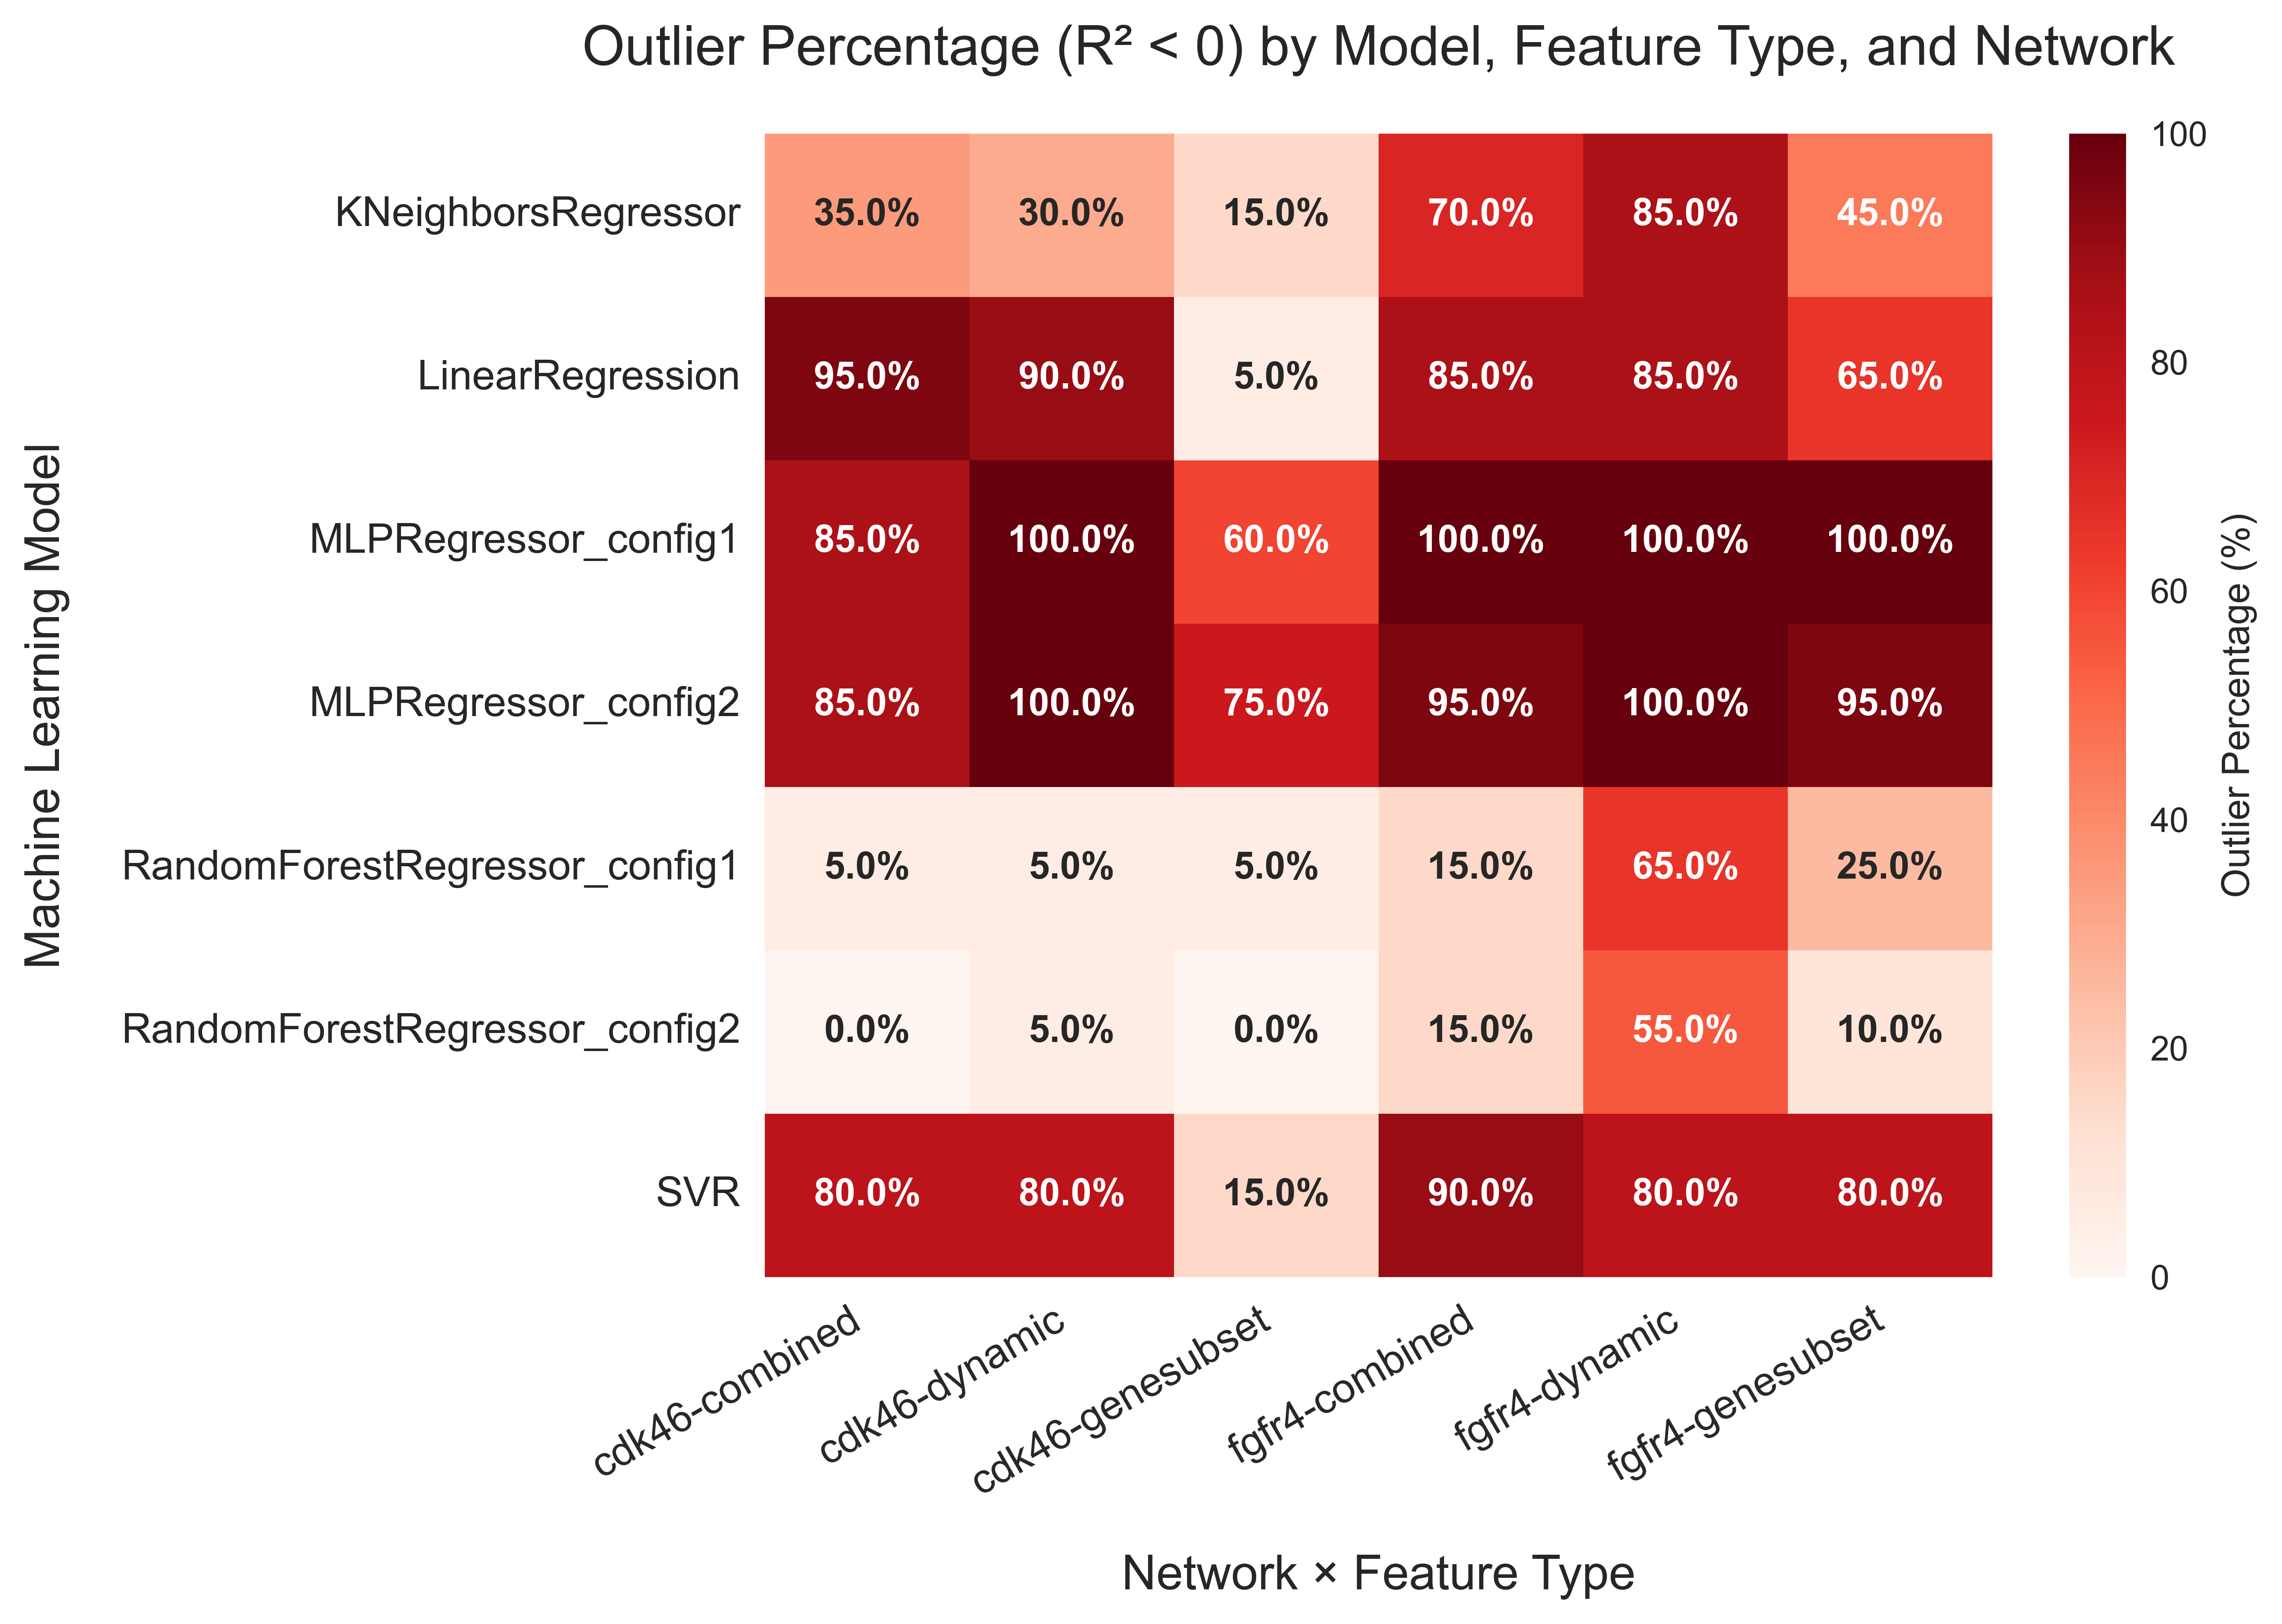

In [18]:
# Create pivot table with all combinations
pivot_data = df_outliers.pivot_table(
    index="model_name",
    columns="network_feature",
    values="condition",
    aggfunc="count",
    fill_value=0,
)

# Calculate total counts for each model×network_feature combination from the original benchmark data
# First create the same network_feature column for the benchmark data
df_benchmark["network_feature"] = (
    df_benchmark["network_type"] + "-" + df_benchmark["dataset_type"]
)

# Create pivot table for total counts
pivot_total = df_benchmark.pivot_table(
    index="model_name",
    columns="network_feature",
    values="condition",
    aggfunc="count",
    fill_value=0,
)

# Reorder columns and rows to match target visualization for both pivot tables
pivot_data = pivot_data.reindex(columns=column_order, index=model_order)
pivot_total = pivot_total.reindex(columns=column_order, index=model_order)

# Calculate percentages (avoid division by zero)
pivot_percentage = (pivot_data / pivot_total * 100).fillna(0)

# Reset style to ensure clean baseline
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Create figure with publication settings
plt.figure(
    figsize=publication_config["figure_size_small"], dpi=publication_config["dpi"]
)
plt.rcParams["font.size"] = publication_config["font_sizes"]["tick"]

# Generate heatmap with proper styling - use pivot_percentage for values but show percentage annotations
ax = sns.heatmap(
    pivot_percentage,  # Use percentage values for coloring
    annot=pivot_percentage.round(1).astype(str)
    + "%",  # Show percentages as annotations
    fmt="",  # Since we're providing pre-formatted strings
    cmap="Reds",
    cbar_kws={"label": "Outlier Percentage (%)"},
    annot_kws={"size": publication_config["font_sizes"]["value"], "weight": "bold"},
)

# Set title with publication config font size
ax.set_title(
    "Outlier Percentage (R² < 0) by Model, Feature Type, and Network",
    fontsize=publication_config["font_sizes"]["title"],
    pad=20,
)

# Set axis labels with publication config font size
ax.set_xlabel(
    "Network × Feature Type",
    fontsize=publication_config["font_sizes"]["axis_label"],
    labelpad=15,
)
ax.set_ylabel(
    "Machine Learning Model",
    fontsize=publication_config["font_sizes"]["axis_label"],
    labelpad=15,
)

# Format tick labels with publication config font size
plt.xticks(rotation=30, ha="right", fontsize=publication_config["font_sizes"]["tick"])
plt.yticks(fontsize=publication_config["font_sizes"]["tick"])

plt.savefig(
    f"{file_save_path}outlier_distribution_heatmap_{exp_id}.png",
    dpi=publication_config["dpi"],
    bbox_inches="tight",
    pad_inches=0.1,
)
plt.show()

## Top Outlier Categories Visualization

## Top Outlier Categories


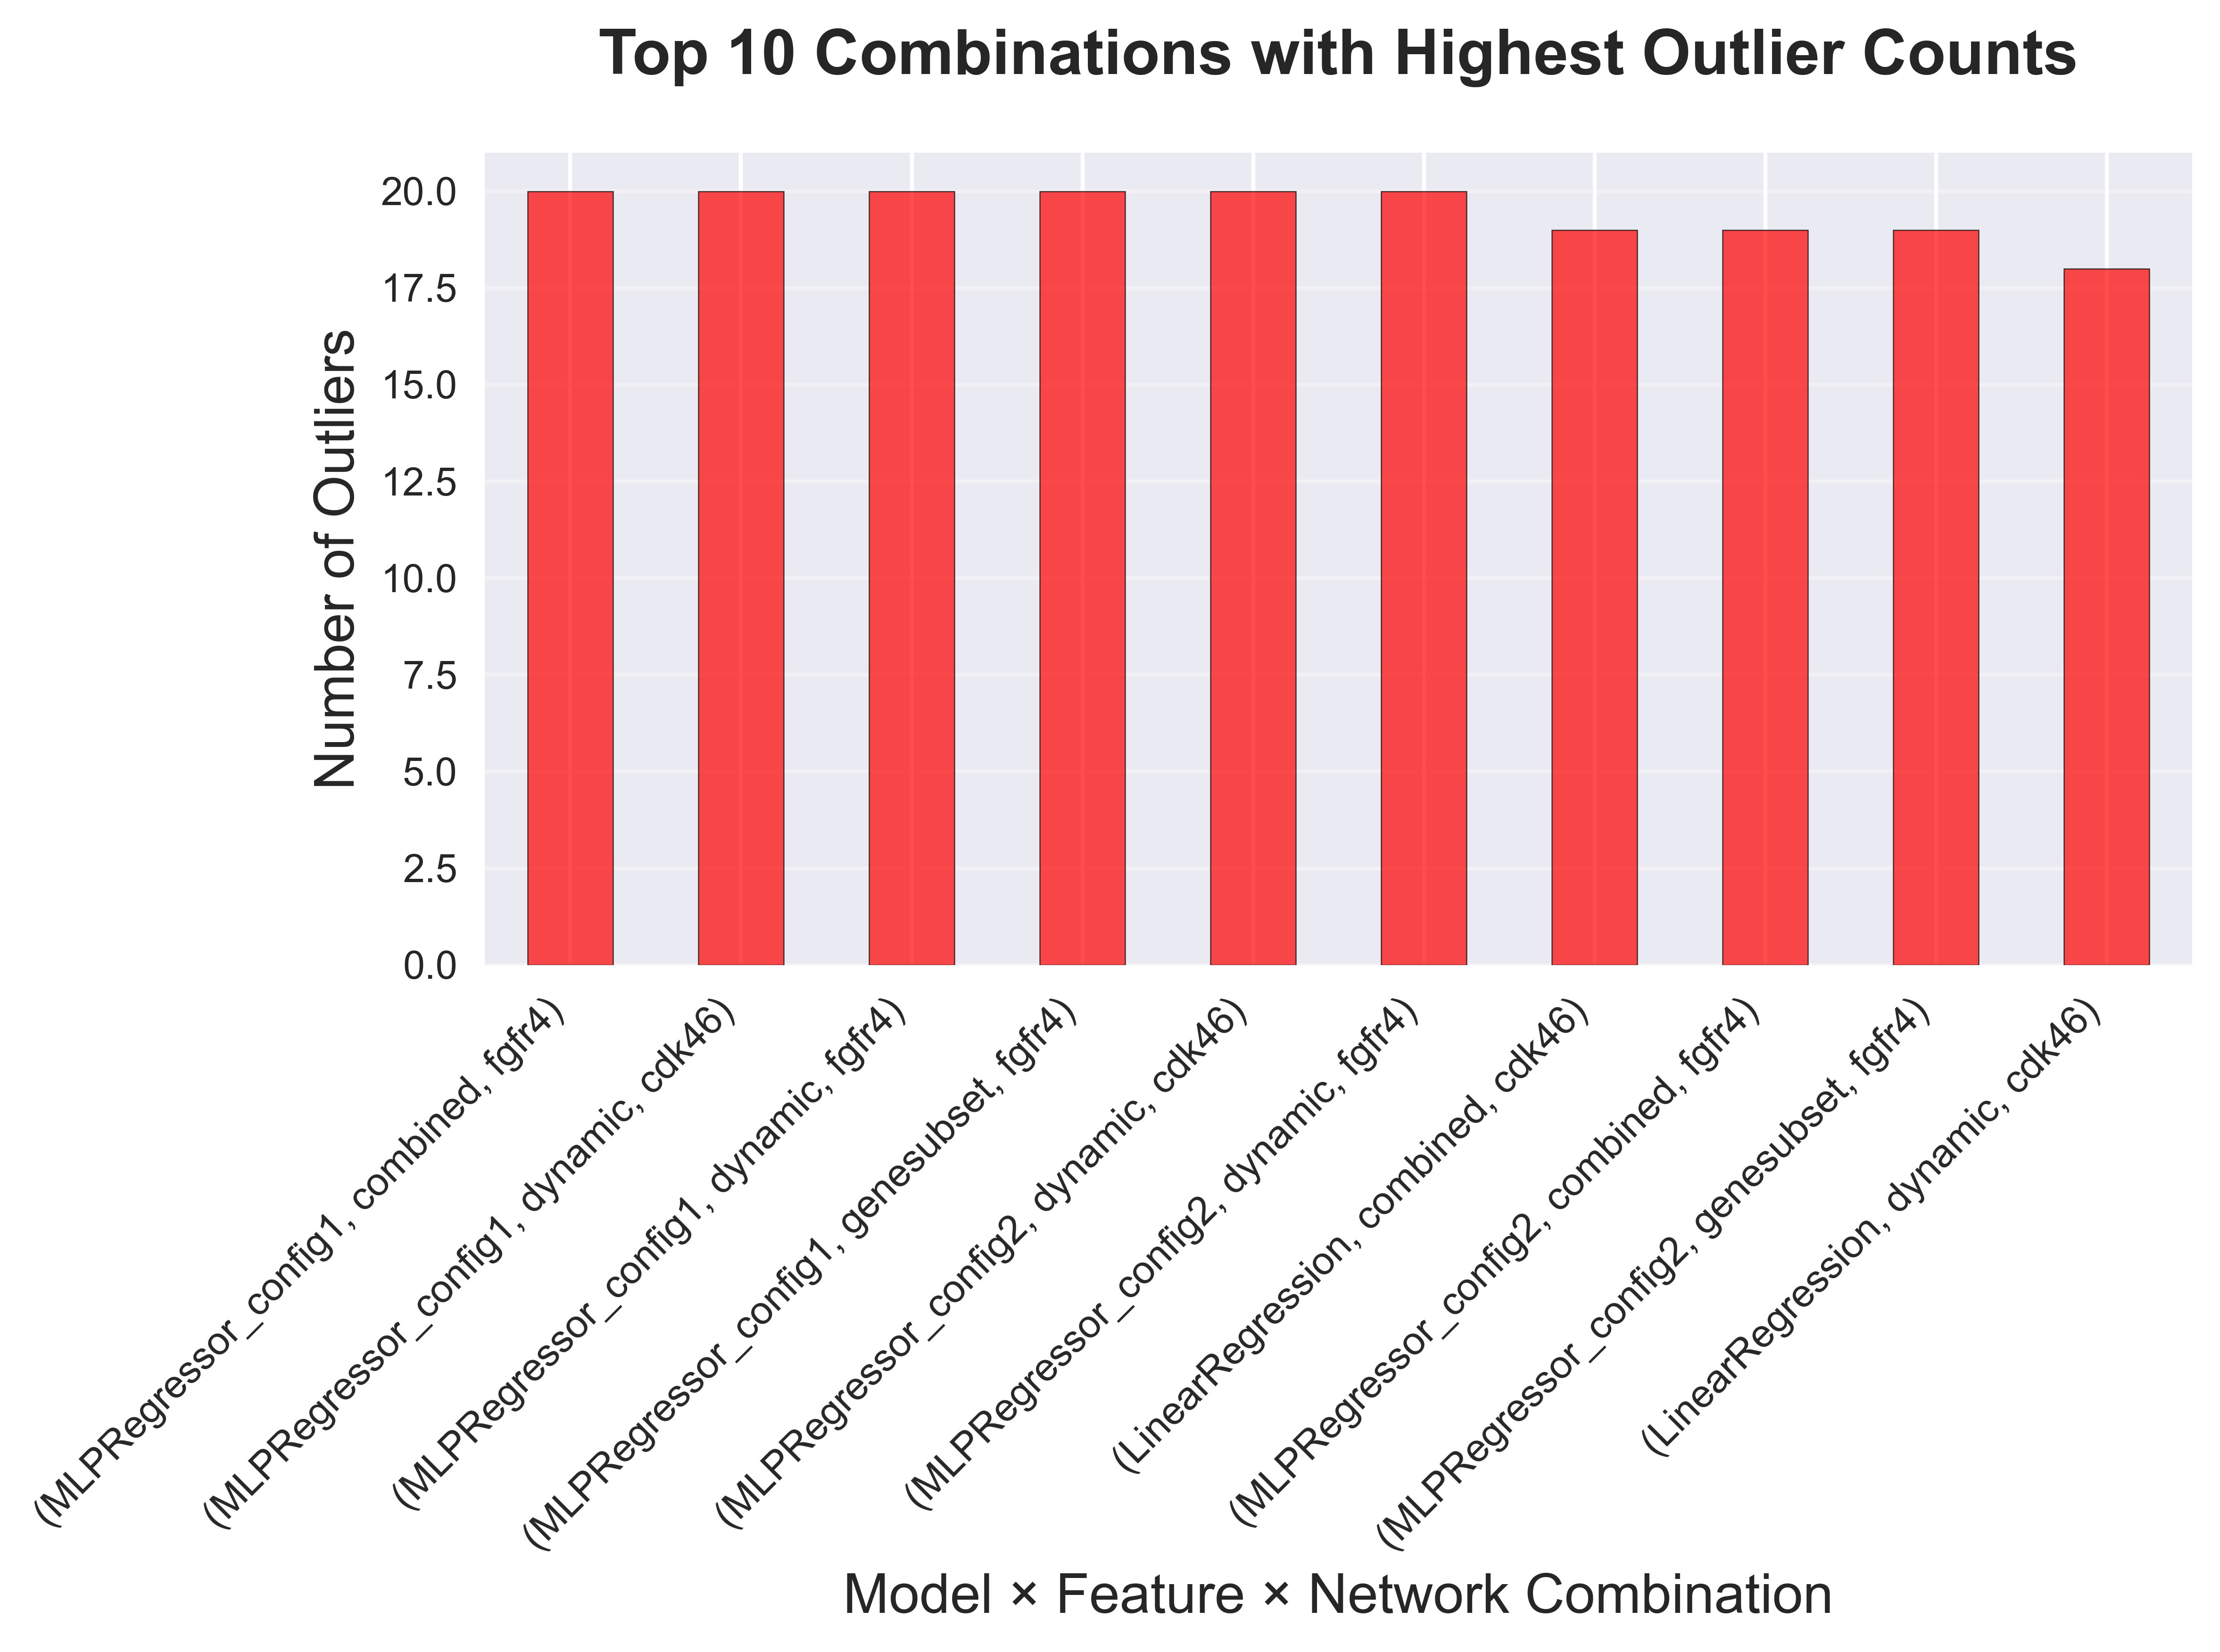

Top outlier combinations:
model_name            dataset_type  network_type
MLPRegressor_config1  combined      fgfr4           20
                      dynamic       cdk46           20
                                    fgfr4           20
                      genesubset    fgfr4           20
MLPRegressor_config2  dynamic       cdk46           20
                                    fgfr4           20
LinearRegression      combined      cdk46           19
MLPRegressor_config2  combined      fgfr4           19
                      genesubset    fgfr4           19
LinearRegression      dynamic       cdk46           18


In [19]:
save_and_print("## Top Outlier Categories", outlier_report_file, level="section")

# Identify top 10 combinations with highest outlier counts
top_outlier_combinations = df_outliers.groupby(['model_name', 'dataset_type', 'network_type']).size().nlargest(10)

plt.figure(figsize=publication_config['figure_size_small'], dpi=publication_config['dpi'])
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']

# Create bar chart of top outlier combinations
top_outlier_combinations.plot(kind='bar', color='red', alpha=0.7, edgecolor='black')
plt.title('Top 10 Combinations with Highest Outlier Counts', 
          fontsize=publication_config['font_sizes']['title'], fontweight='bold', pad=20)
plt.xlabel('Model × Feature × Network Combination', fontsize=publication_config['font_sizes']['axis_label'])
plt.ylabel('Number of Outliers', fontsize=publication_config['font_sizes']['axis_label'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{file_save_path}top_outlier_combinations_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Top outlier combinations:", outlier_report_file, level="subsection")
save_and_print(top_outlier_combinations.to_string(), outlier_report_file, level="info")

## Key Findings and Summary

In [20]:
save_and_print("## Key Findings and Summary", outlier_report_file, level="section")

# Identify worst-performing combinations
max_outlier_count = top_outlier_combinations.max()
worst_combination = top_outlier_combinations.idxmax()

save_and_print("### Worst Performing Combination", outlier_report_file, level="subsection")
save_and_print(f"Combination with most outliers: {worst_combination}", outlier_report_file, level="info")
save_and_print(f"Number of outliers: {max_outlier_count}", outlier_report_file, level="info")

# Model with highest outlier percentage
worst_model = model_summary.loc[model_summary['outlier_percentage'].idxmax()]
save_and_print(f"Model with highest outlier percentage: {worst_model.name}", outlier_report_file, level="info")
save_and_print(f"Outlier percentage: {worst_model['outlier_percentage']}%", outlier_report_file, level="info")

# Feature type with highest outlier percentage
worst_feature = feature_outlier_stats.loc[feature_outlier_stats['outlier_percentage'].idxmax()]
save_and_print(f"Feature type with highest outlier percentage: {worst_feature.name}", outlier_report_file, level="info")
save_and_print(f"Outlier percentage: {worst_feature['outlier_percentage']}%", outlier_report_file, level="info")

# Network with highest outlier percentage
worst_network = network_outlier_stats.loc[network_outlier_stats['outlier_percentage'].idxmax()]
save_and_print(f"Network with highest outlier percentage: {worst_network.name}", outlier_report_file, level="info")
save_and_print(f"Outlier percentage: {worst_network['outlier_percentage']}%", outlier_report_file, level="info")

save_and_print("### Recommendations", outlier_report_file, level="subsection")
save_and_print("1. Focus investigation on combinations with highest outlier rates", outlier_report_file, level="info")
save_and_print("2. Consider removing consistently poor-performing models from future benchmarks", outlier_report_file, level="info")
save_and_print("3. Analyze feature engineering for problematic feature types", outlier_report_file, level="info")
save_and_print("4. Investigate network-specific data quality issues", outlier_report_file, level="info")

# Close the report file
outlier_report_file.close()
print(f"Outlier analysis report saved to: {outlier_report_path}")

## Key Findings and Summary
### Worst Performing Combination
Combination with most outliers: ('MLPRegressor_config1', 'combined', 'fgfr4')
Number of outliers: 20
Model with highest outlier percentage: MLPRegressor_config2
Outlier percentage: 91.7%
Feature type with highest outlier percentage: dynamic
Outlier percentage: 70.0%
Network with highest outlier percentage: fgfr4
Outlier percentage: 69.5%
### Recommendations
1. Focus investigation on combinations with highest outlier rates
2. Consider removing consistently poor-performing models from future benchmarks
3. Analyze feature engineering for problematic feature types
4. Investigate network-specific data quality issues
Outlier analysis report saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-4-ModelSelectionGeneSubsets/v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4/outlier_analysis_report_v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4.md


In [21]:
print("Outlier analysis completed successfully!")
print(f"All visualizations saved to: {file_save_path}")
print(f"Total outliers analyzed: {outlier_count} out of {total_rows} runs ({outlier_percentage:.1f}%)")

Outlier analysis completed successfully!
All visualizations saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-4-ModelSelectionGeneSubsets/v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4/
Total outliers analyzed: 486 out of 840 runs (57.9%)
